# Zero dimensional li-s model

In this notebook we solve the model given in [2]. 

## References

[1]  Marinescu, M., Zhang, T. & Offer, G. J. (2016). A zero dimensional model of lithium-sulfur batteries during charge and discharge. Physical Chemistry Chemical Physics, 18, 584-593.

[2]  Marinescu, M., O’Neill, L., Zhang, T., Walus, S., Wilson, T. E., & Offer, G. J. (2018). Irreversible vs reversible capacity fade of lithium-sulfur batteries during The Electrochemical Society, 165(1), A6107-A6118.

In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt

We first load the model and update the parameter values to match those given in the paper

In [2]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016()

# Update current and ICs to correspond to initial 2.4V as in ref [2]
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": 1.7,
        "Initial Condition for S8 ion [g]": 2.6730,
        "Initial Condition for S4 ion [g]": 0.0128,
        "Initial Condition for S2 ion [g]": 4.3321e-6,
        "Initial Condition for S ion [g]": 1.6321e-6,
        "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
        "Initial Condition for Terminal Voltage [V]": 2.4,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
    }
)

We then set up and solve the simulation

In [3]:
# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
    ),
)
sim.solve(np.linspace(0, 7000, 700))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../c

In [4]:
timer = pybamm.Timer()
print("Solution time: ", timer.format(sim.solution.solve_time))
print("Final time: ", timer.format(sim.solution.t[-1]))
print("Termination reason: ", sim.solution.termination)

Solution time:  1.515 s
Final time:  1 hour, 51 minutes, 43 seconds
Termination reason:  event: Zero theoretical capacity


We see that the solver stopped when zero theoretical capacity.

Now we can extract the variables we are interested in from the solution object and plot the results.

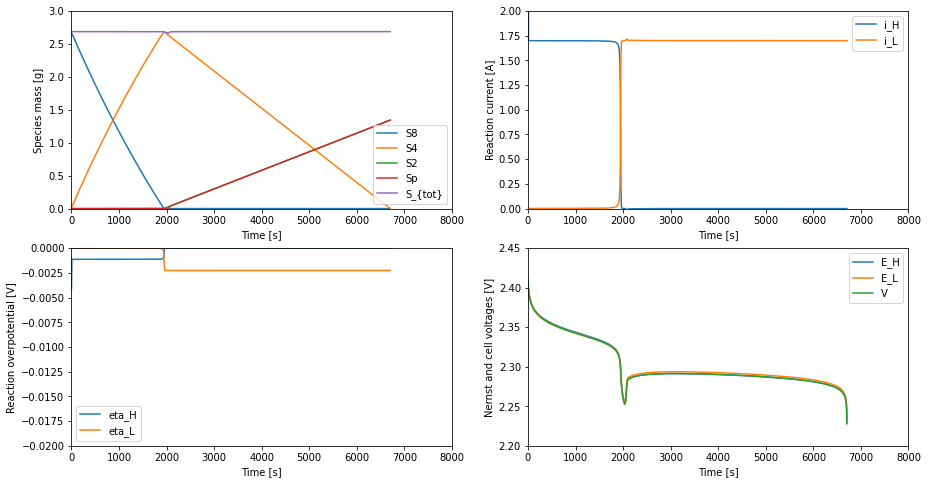

In [5]:
# extract variables 
t = sim.solution["Time [s]"].entries
S8 = sim.solution["S8 [g]"].entries
S4 = sim.solution["S4 [g]"].entries
S2 = sim.solution["S2 [g]"].entries
Sp = sim.solution["Precipitated Sulfur [g]"].entries
S_tot = S8 + S4 + S2 + Sp
i_H = sim.solution["High plateau current [A]"].entries
i_L = sim.solution["Low plateau current [A]"].entries
eta_H = sim.solution["High plateau over-potential [V]"].entries
eta_L = sim.solution["Low plateau over-potential [V]"].entries
E_H = sim.solution["High plateau potential [V]"].entries
E_L = sim.solution["Low plateau potential [V]"].entries
V = sim.solution["Terminal voltage [V]"].entries

# set up figure and plot
fig, ax = plt.subplots(2, 2, figsize=(15,8))

ax[0, 0].plot(t, S8, label="S8")
ax[0, 0].plot(t, S4, label="S4")
ax[0, 0].plot(t, S2, label="S2")
ax[0, 0].plot(t, Sp, label="Sp")
ax[0, 0].plot(t, S_tot, label="S_{tot}")
ax[0, 0].set_xlim([0, 8000])
ax[0, 0].set_ylim([0, 3])
ax[0, 0].set_xlabel("Time [s]")
ax[0, 0].set_ylabel("Species mass [g]")
ax[0, 0].legend()

ax[0, 1].plot(t, i_H, label="i_H")
ax[0, 1].plot(t, i_L, label="i_L")
ax[0, 1].set_xlim([0, 8000])
ax[0, 1].set_ylim([0, 2])
ax[0, 1].set_xlabel("Time [s]")
ax[0, 1].set_ylabel("Reaction current [A]")
ax[0, 1].legend()

ax[1, 0].plot(t, eta_H, label="eta_H")
ax[1, 0].plot(t, eta_L, label="eta_L")
ax[1, 0].set_xlim([0, 8000])
ax[1, 0].set_ylim([-20e-3, 0])
ax[1, 0].set_xlabel("Time [s]")
ax[1, 0].set_ylabel("Reaction overpotential [V]")
ax[1, 0].legend()

ax[1, 1].plot(t, E_H, label="E_H")
ax[1, 1].plot(t, E_L, label="E_L")
ax[1, 1].plot(t, V, label="V")
ax[1, 1].set_xlim([0, 8000])
ax[1, 1].set_ylim([2.2, 2.45])
ax[1, 1].set_xlabel("Time [s]")
ax[1, 1].set_ylabel("Nernst and cell voltages [V]")
ax[1, 1].legend()

## Speeding up the solve time

We see that the solution ended because we hit an "event". We can speed up the solve time by using the `CasadiSolver` in "fast" mode, but this doesn't support events. Instead we can solve up to a time just before the event was hit, and see that the solve time is reduced.

In [6]:
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="fast", extra_options_setup={"max_step_size": 0.1}
    ),
)
sim.solve(np.linspace(0, 6680, 680))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed


In [7]:
timer = pybamm.Timer()
print("Solution time: ", timer.format(sim.solution.solve_time))
print("Final time: ", timer.format(sim.solution.t[-1]))
print("Termination reason: ", sim.solution.termination)

Solution time:  490.976 ms
Final time:  1 hour, 51 minutes, 20 seconds
Termination reason:  final time


In [8]:
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.8555555555555556, step=0.01855555555555555…